<a href="https://colab.research.google.com/github/sumantamohapatra/goal_setters/blob/main/Scada_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
"""
SCADA Power System Anomaly Detection Model
Professional Implementation for Solar Power Generation Data
Author: AI/ML Developer
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import joblib
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Statistical Libraries
from scipy import stats
from scipy.spatial.distance import mahalanobis
import joblib

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [46]:
class SCADAAnomalyDetector:
    def __init__(self, contamination=0.1):
        self.contamination = contamination
        self.models = {}
        self.scalers = {}
        self.feature_stats = {}
        self.results = {}
        self.model_dir = "models"
        os.makedirs(self.model_dir, exist_ok=True)
    def load_data(self, file_path):
        self.df = pd.read_csv(file_path)
        print(f"✓ Loaded {len(self.df)} records from {file_path}")
        print(f"✓ Columns: {list(self.df.columns)}")
        print(f"✓ Data shape: {self.df.shape}")
        print("\nDataset Info:")
        print(self.df.info())
        print("\nFirst few records:")
        print(self.df.head())
        return self.df
    def preprocess_data(self):
        self.df['DATE_TIME'] = pd.to_datetime(
            self.df['DATE_TIME'], format='%d-%m-%Y %H:%M'
        )
        self.df = self.df.sort_values('DATE_TIME').reset_index(drop=True)
        self.df['hour']        = self.df['DATE_TIME'].dt.hour
        self.df['day']         = self.df['DATE_TIME'].dt.day
        self.df['month']       = self.df['DATE_TIME'].dt.month
        self.df['day_of_week'] = self.df['DATE_TIME'].dt.dayofweek

        # Derived metrics
        self.df['efficiency'] = self.df['AC_POWER'] / self.df['DC_POWER']
        self.df['power_loss'] = self.df['DC_POWER'] - self.df['AC_POWER']
        self.df['power_loss_ratio'] = self.df['power_loss'] / self.df['DC_POWER']
        self.df['yield_per_dc_power'] = self.df['DAILY_YIELD'] / self.df['DC_POWER']
        self.df['yield_per_ac_power'] = self.df['DAILY_YIELD'] / self.df['AC_POWER']

        # Replace infs and fill nulls with median
        num_cols = self.df.select_dtypes(include=[np.number]).columns
        self.df[num_cols] = self.df[num_cols].replace([np.inf, -np.inf], np.nan)
        self.df[num_cols] = self.df[num_cols].fillna(self.df[num_cols].median())

        print("✓ Datetime & feature engineering done")
        print(f"✓ Final shape: {self.df.shape}")
        self.feature_stats = self.df.describe()
        print("\nEngineered Features Summary:")
        engineered_features = ['efficiency', 'power_loss', 'power_loss_ratio',
                             'yield_per_dc_power', 'yield_per_ac_power']
        print(self.df[engineered_features].describe())
        return self.df
    def exploratory_data_analysis(self):
        print(f"• Total records: {len(self.df):,}")
        print(f"• Unique inverters: {self.df['SOURCE_KEY'].nunique()}")
        print(f"• Date range: {self.df['DATE_TIME'].min()} → {self.df['DATE_TIME'].max()}")
        print(f"• Plants: {self.df['PLANT_ID'].nunique()}")
        print(f"• Avg DC Power: {self.df['DC_POWER'].mean():.2f} kW")
        print(f"• Avg AC Power: {self.df['AC_POWER'].mean():.2f} kW")
        print(f"• Avg Efficiency: {self.df['efficiency'].mean() * 100:.2f}%")
        self._create_eda_plots()
    def _create_eda_plots(self):
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle('SCADA Data - Exploratory Data Analysis', fontsize=16, fontweight='bold')
        # 1. Power distribution
        axes[0,0].hist(self.df['DC_POWER'], bins=50, alpha=0.7, color='blue', label='DC Power')
        axes[0,0].hist(self.df['AC_POWER'], bins=50, alpha=0.7, color='red', label='AC Power')
        axes[0,0].set_title('Power Distribution')
        axes[0,0].set_xlabel('Power (kW)')
        axes[0,0].legend()
        # 2. Efficiency distribution
        axes[0,1].hist(self.df['efficiency'], bins=50, alpha=0.7, color='green')
        axes[0,1].set_title('Efficiency Distribution')
        axes[0,1].set_xlabel('Efficiency Ratio')
        # 3. Daily yield distribution
        axes[0,2].hist(self.df['DAILY_YIELD'], bins=50, alpha=0.7, color='orange')
        axes[0,2].set_title('Daily Yield Distribution')
        axes[0,2].set_xlabel('Daily Yield (kWh)')
        # 4. Power vs Efficiency scatter
        axes[1,0].scatter(self.df['DC_POWER'], self.df['efficiency'], alpha=0.6, s=1)
        axes[1,0].set_title('DC Power vs Efficiency')
        axes[1,0].set_xlabel('DC Power (kW)')
        axes[1,0].set_ylabel('Efficiency')
        # 5. Hourly average power
        hourly_avg = self.df.groupby('hour')[['DC_POWER', 'AC_POWER']].mean()
        axes[1,1].plot(hourly_avg.index, hourly_avg['DC_POWER'], marker='o', label='DC Power')
        axes[1,1].plot(hourly_avg.index, hourly_avg['AC_POWER'], marker='s', label='AC Power')
        axes[1,1].set_title('Average Power by Hour')
        axes[1,1].set_xlabel('Hour of Day')
        axes[1,1].set_ylabel('Power (kW)')
        axes[1,1].legend()
        # 6. Power loss vs DC power
        axes[1,2].scatter(self.df['DC_POWER'], self.df['power_loss'], alpha=0.6, s=1, color='red')
        axes[1,2].set_title('DC Power vs Power Loss')
        axes[1,2].set_xlabel('DC Power (kW)')
        axes[1,2].set_ylabel('Power Loss (kW)')
        # 7. Correlation heatmap
        numeric_cols = ['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'efficiency', 'power_loss_ratio']
        corr_matrix = self.df[numeric_cols].corr()
        im = axes[2,0].imshow(corr_matrix, cmap='coolwarm', aspect='auto')
        axes[2,0].set_xticks(range(len(numeric_cols)))
        axes[2,0].set_yticks(range(len(numeric_cols)))
        axes[2,0].set_xticklabels(numeric_cols, rotation=45)
        axes[2,0].set_yticklabels(numeric_cols)
        axes[2,0].set_title('Feature Correlation Matrix')
        for i in range(len(numeric_cols)):
            for j in range(len(numeric_cols)):
                axes[2,0].text(j, i, f'{corr_matrix.iloc[i,j]:.2f}', ha='center', va='center', fontweight='bold')
        # 8. Box plot: efficiency by hour
        hour_eff_data = [self.df[self.df['hour']==h]['efficiency'].dropna() for h in range(24)]
        axes[2,1].boxplot(hour_eff_data, labels=range(24))
        axes[2,1].set_title('Efficiency Distribution by Hour')
        axes[2,1].set_xlabel('Hour of Day')
        axes[2,1].set_ylabel('Efficiency')
        # 9. Bar chart: avg efficiency by top 10 inverters
        top_sources = self.df['SOURCE_KEY'].value_counts().head(10).index
        source_eff = self.df[self.df['SOURCE_KEY'].isin(top_sources)].groupby('SOURCE_KEY')['efficiency'].mean()
        axes[2,2].bar(range(len(source_eff)), source_eff.values)
        axes[2,2].set_title('Top 10 Sources - Average Efficiency')
        axes[2,2].set_xlabel('Source Index')
        axes[2,2].set_ylabel('Average Efficiency')
        plt.tight_layout()
        plt.savefig('scada_eda_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ EDA plots saved as 'scada_eda_analysis.png'")

    def prepare_features(self, feature_cols=None, scaler_type='robust'):
        if feature_cols is None:
            feature_cols = [
                'DC_POWER', 'AC_POWER', 'efficiency', 'power_loss',
                'power_loss_ratio', 'yield_per_dc_power',
                'yield_per_ac_power', 'hour', 'day', 'day_of_week'
            ]

        print(f"✓ Selected features: {feature_cols}")
        self.feature_cols = feature_cols

        # Normalize features per inverter
        grouped = self.df.groupby("SOURCE_KEY")
        self.feature_matrix = {}

        for key, group in grouped:
            data = group[feature_cols].copy()
            data = data.replace([np.inf, -np.inf], np.nan)
            data = data.fillna(data.median())

            # Choose scaler
            if scaler_type == 'robust':
                scaler = RobustScaler()
            else:
                scaler = StandardScaler()

            scaled = scaler.fit_transform(data)
            self.feature_matrix[key] = pd.DataFrame(
                scaled,
                columns=feature_cols,
                index=group.index
            )

            self.scalers[key] = scaler

        print(f"✓ Features prepared for {len(self.feature_matrix)} inverters")

    def train_isolation_forest(self, n_estimators=100, contamination=None, random_state=42):
        self.models = {}
        self.anomaly_results = {}
        model_dir = "models"
        os.makedirs(model_dir, exist_ok=True)

        for inverter_id, X in self.feature_matrix.items():
            model_path = os.path.join(model_dir, f"{inverter_id}_isoforest.pkl")
            if os.path.exists(model_path):
                print(f"• Loading model for inverter: {inverter_id}")
                model = joblib.load(model_path)
            else:
                print(f"• Training model for inverter: {inverter_id}")
                model = IsolationForest(
                    n_estimators=n_estimators,
                    contamination=contamination or self.contamination,
                    random_state=random_state
                )
                model.fit(X)
                joblib.dump(model, model_path)
                print(f"✓ Model saved: {model_path}")
            self.models[inverter_id] = model
            preds = model.predict(X)  # -1 = anomaly, 1 = normal
            scores = model.decision_function(X)  # The higher, the more normal

            # Store results
            results = pd.DataFrame({
                'SOURCE_KEY': inverter_id,
                'anomaly_label': preds,
                'anomaly_score': scores
            }, index=X.index)

            self.anomaly_results[inverter_id] = results

        print(f"✓ Models trained for {len(self.models)} inverters")
    def plot_anomalies(self, inverter_id, save_path='plots/'):
        if inverter_id not in self.anomaly_results:
            print(f"✗ Inverter {inverter_id} not found.")
            return

        os.makedirs(save_path, exist_ok=True)
        inverter_df = self.df[self.df['SOURCE_KEY'] == inverter_id].copy()
        results = self.anomaly_results[inverter_id]
        merged = inverter_df.join(results[['anomaly_label', 'anomaly_score']])

        # Plot
        fig, ax1 = plt.subplots(figsize=(15, 6))

        # Score line
        ax1.plot(merged['DATE_TIME'], merged['anomaly_score'], label='Anomaly Score', color='blue')

        # Highlight anomalies
        anomalies = merged[merged['anomaly_label'] == -1]
        ax1.scatter(anomalies['DATE_TIME'], anomalies['anomaly_score'], color='red', label='Anomaly', s=20)

        ax1.set_title(f"Anomaly Scores Over Time - {inverter_id}")
        ax1.set_xlabel("Date Time")
        ax1.set_ylabel("Anomaly Score")
        ax1.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()

        filename = os.path.join(save_path, f"anomaly_plot_{inverter_id}.png")
        plt.savefig(filename, dpi=300)
        plt.show()

        print(f"✓ Anomaly plot saved to: {filename}")

    def export_anomalies(self, output_dir='anomalies/'):
        os.makedirs(output_dir, exist_ok=True)
        total_exported = 0

        for inverter_id, results in self.anomaly_results.items():
            df = self.df[self.df['SOURCE_KEY'] == inverter_id].copy()
            merged = df.join(results[['anomaly_label', 'anomaly_score']])

            anomalies = merged[merged['anomaly_label'] == -1]

            if not anomalies.empty:
                filename = os.path.join(output_dir, f"anomalies_{inverter_id}.csv")
                anomalies.to_csv(filename, index=False)
                total_exported += len(anomalies)
                print(f"✓ Saved {len(anomalies)} anomalies → {filename}")

        print(f"\n✓ Total anomalies exported: {total_exported}")
    def implement_statistical_methods(self, z_thresh=3.0):

        self.statistical_scores = {}

        # Choose numeric columns only
        numeric_cols = [
            'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD',
            'efficiency', 'power_loss', 'power_loss_ratio',
            'yield_per_dc_power', 'yield_per_ac_power'
        ]

        stats_df = self.df[numeric_cols].copy()

        # ------------------ Z-Score ------------------
        z_scores = (stats_df - stats_df.mean()) / stats_df.std()
        z_anomalies = (z_scores.abs() > z_thresh).any(axis=1)

        # ------------------ Modified Z-Score ------------------
        median = stats_df.median()
        mad = (stats_df - median).abs().median()
        mod_z_scores = 0.6745 * (stats_df - median) / mad
        mod_z_anomalies = (mod_z_scores.abs() > 3.5).any(axis=1)

        # ------------------ IQR ------------------
        Q1 = stats_df.quantile(0.25)
        Q3 = stats_df.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_anomalies = ((stats_df < lower_bound) | (stats_df > upper_bound)).any(axis=1)

        # Store scores
        self.statistical_scores['z_score'] = z_scores
        self.statistical_scores['modified_z_score'] = mod_z_scores
        self.statistical_scores['iqr_lower'] = lower_bound
        self.statistical_scores['iqr_upper'] = upper_bound

        # Create final DataFrame
        self.df['stat_z_score_anomaly'] = z_anomalies.astype(int)
        self.df['stat_mod_z_anomaly'] = mod_z_anomalies.astype(int)
        self.df['stat_iqr_anomaly'] = iqr_anomalies.astype(int)

        print("✓ Z-Score, Modified Z-Score, and IQR anomalies marked in main dataframe")
    def export_combined_anomaly_report(self, output_path='anomaly_report.csv'):
        combined_rows = []
        for inverter_id, results in self.anomaly_results.items():
            base_df = self.df[self.df['SOURCE_KEY'] == inverter_id].copy()
            merged = base_df.join(results[['anomaly_label', 'anomaly_score']])
            merged['inverter_anomaly'] = (merged['anomaly_label'] == -1).astype(int)

            combined_rows.append(merged)

        full_df = pd.concat(combined_rows)

        # Merge statistical anomalies
        stat_cols = ['stat_z_score_anomaly', 'stat_mod_z_anomaly', 'stat_iqr_anomaly']
        full_df['statistical_anomaly'] = full_df[stat_cols].sum(axis=1).clip(upper=1)

        # Final flag
        full_df['final_anomaly'] = ((full_df['inverter_anomaly'] == 1) | (full_df['statistical_anomaly'] == 1)).astype(int)

        # Optional source label
        full_df['anomaly_source'] = full_df.apply(lambda row:
            'both' if row['inverter_anomaly'] == 1 and row['statistical_anomaly'] == 1 else
            'model' if row['inverter_anomaly'] == 1 else
            'statistical' if row['statistical_anomaly'] == 1 else
            'none', axis=1
        )

        # Save
        full_df.to_csv(output_path, index=False)
        print(f"✓ Final anomaly report saved to: {output_path}")
        print(f"✓ Total anomalies detected: {full_df['final_anomaly'].sum()}")



EDA

Driver code

✓ Loaded 68778 records from /content/Generation_Data.csv
✓ Columns: ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
✓ Data shape: (68778, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB
None

First few records:
          DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 0

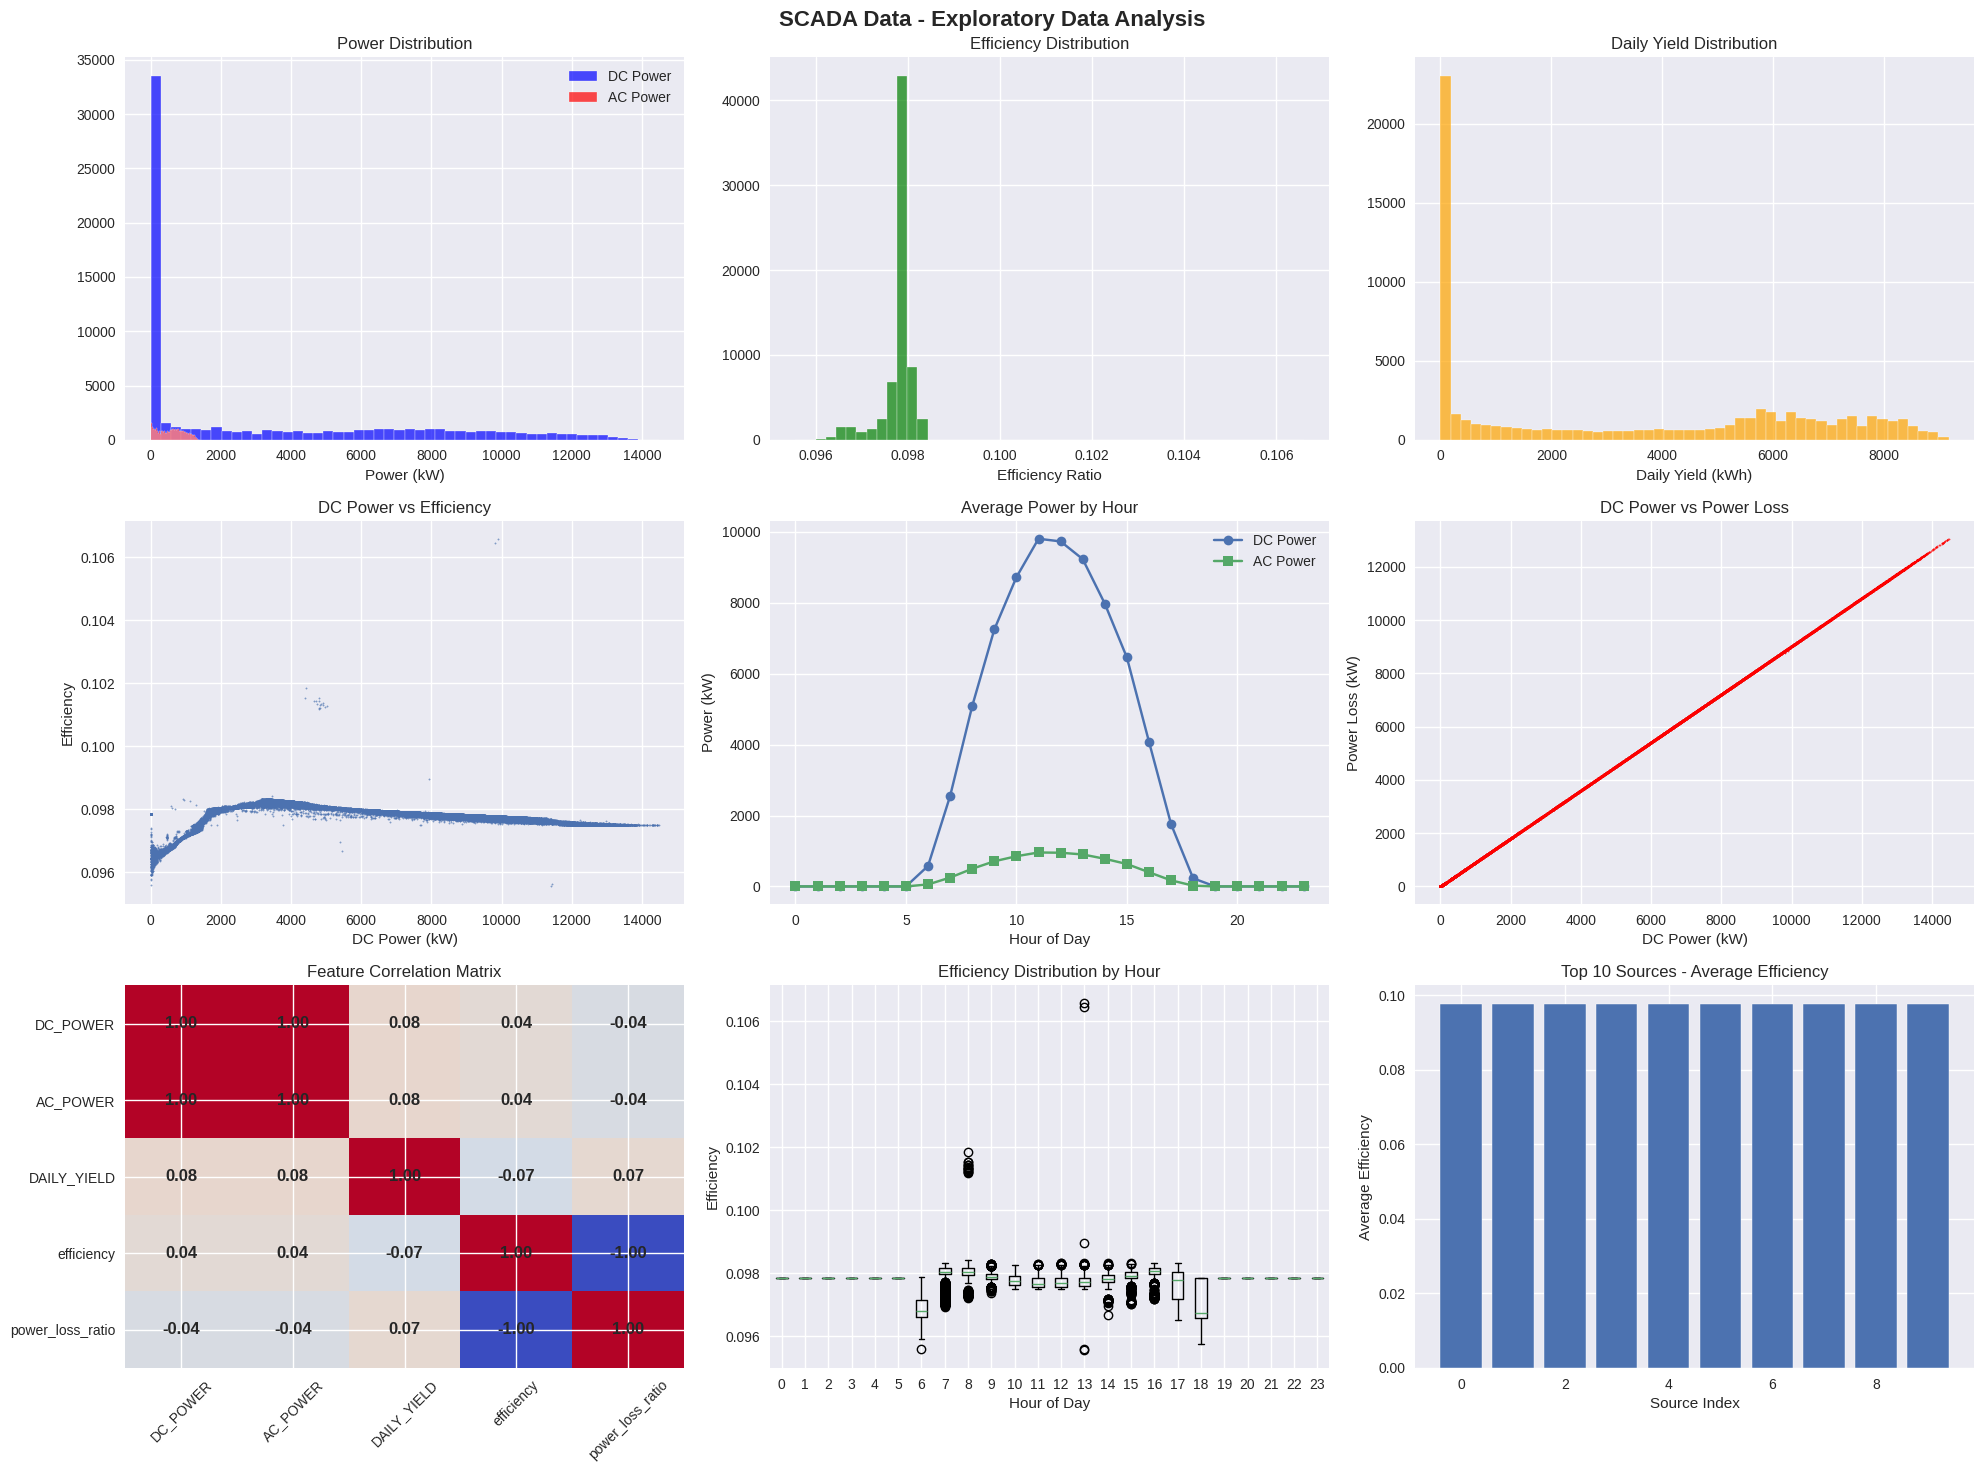

✓ EDA plots saved as 'scada_eda_analysis.png'
✓ Selected features: ['DC_POWER', 'AC_POWER', 'efficiency', 'power_loss', 'power_loss_ratio', 'yield_per_dc_power', 'yield_per_ac_power', 'hour', 'day', 'day_of_week']
✓ Features prepared for 22 inverters
✓ Models trained for 22 inverters


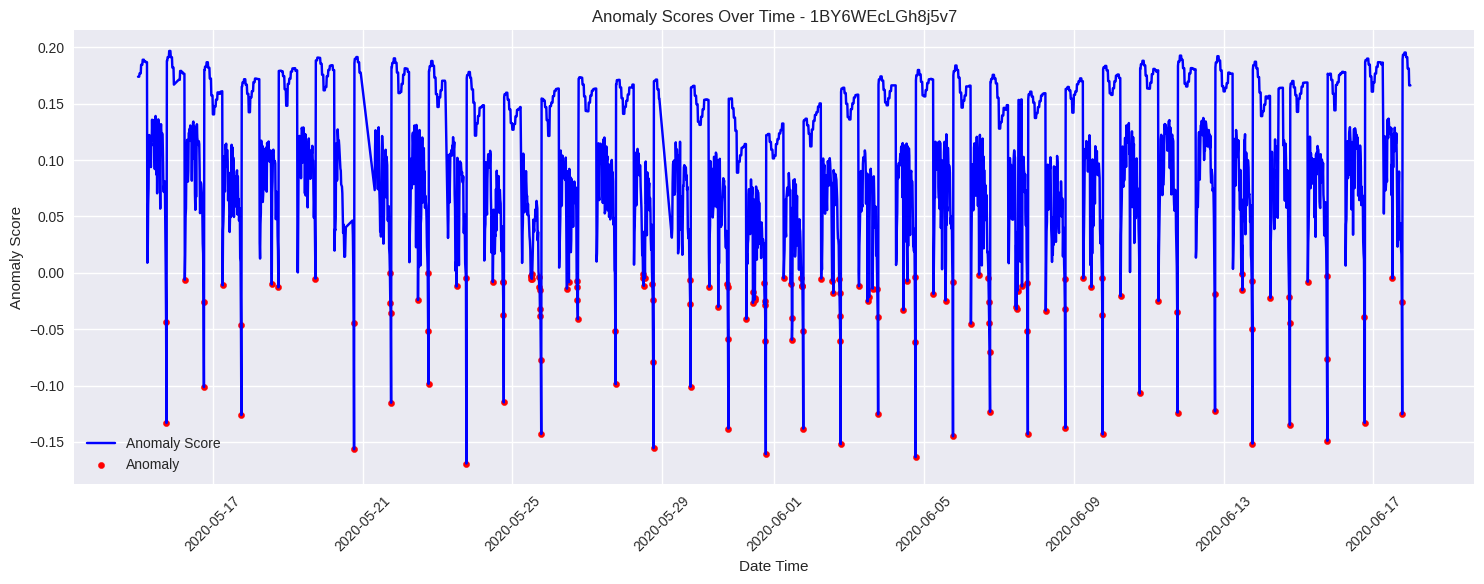

✓ Anomaly plot saved to: plots/anomaly_plot_1BY6WEcLGh8j5v7.png


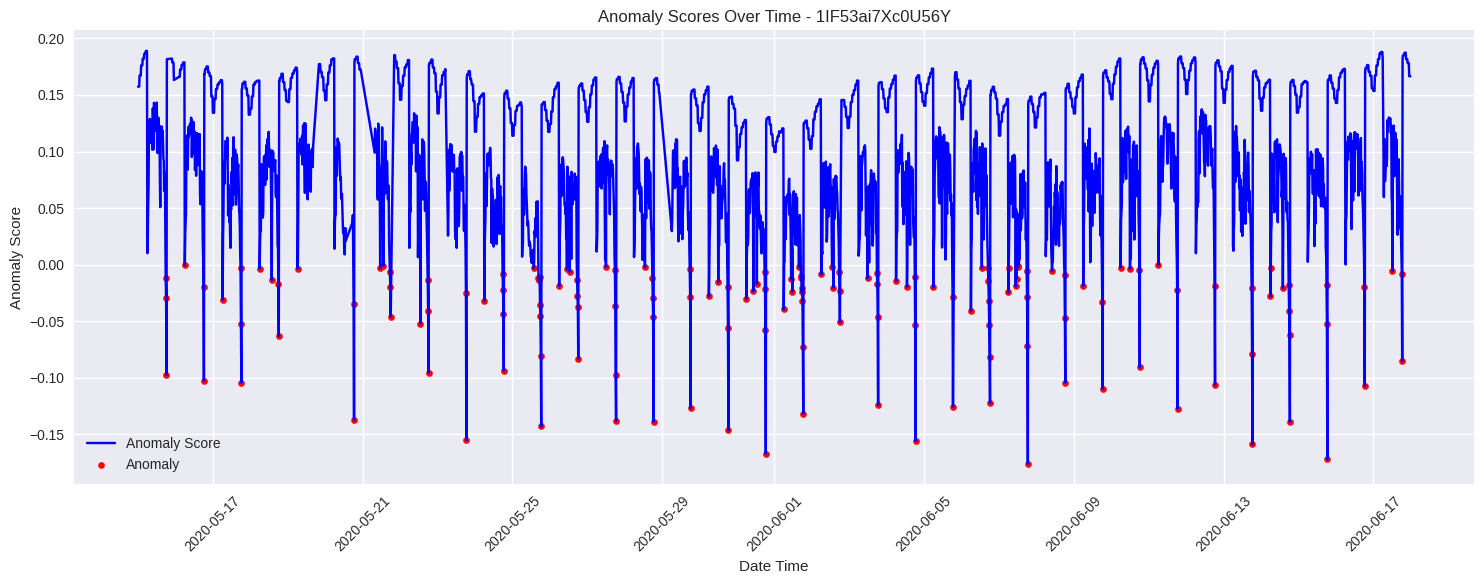

✓ Anomaly plot saved to: plots/anomaly_plot_1IF53ai7Xc0U56Y.png


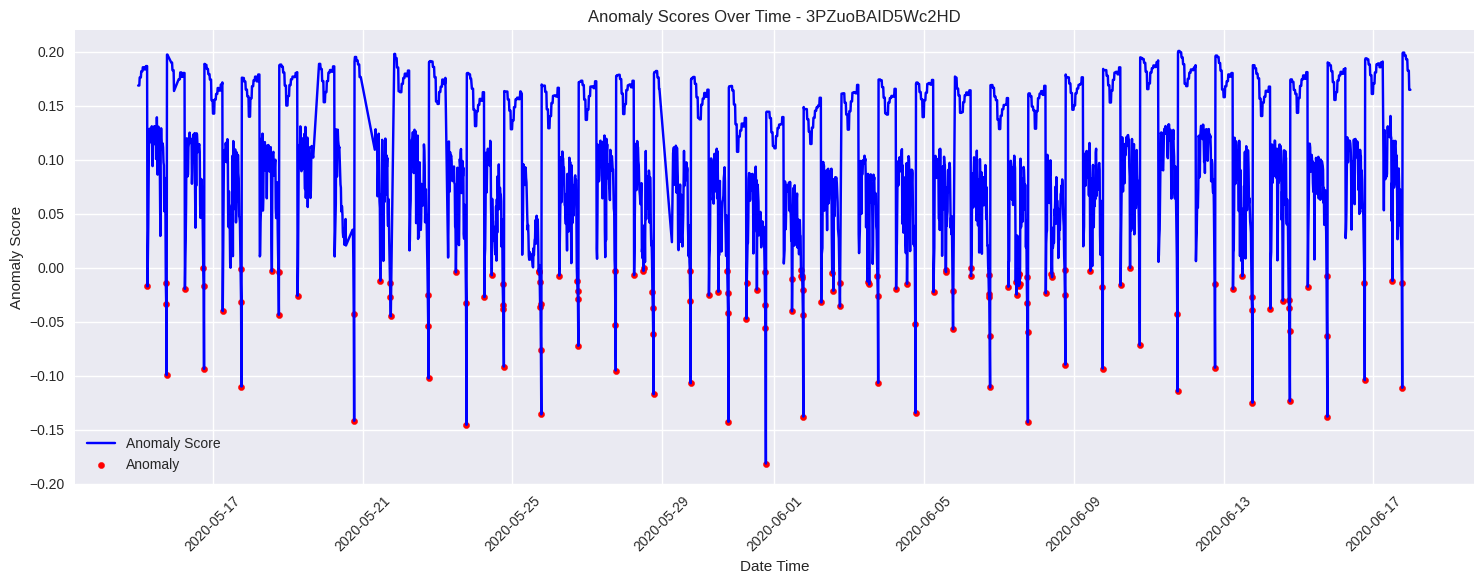

✓ Anomaly plot saved to: plots/anomaly_plot_3PZuoBAID5Wc2HD.png


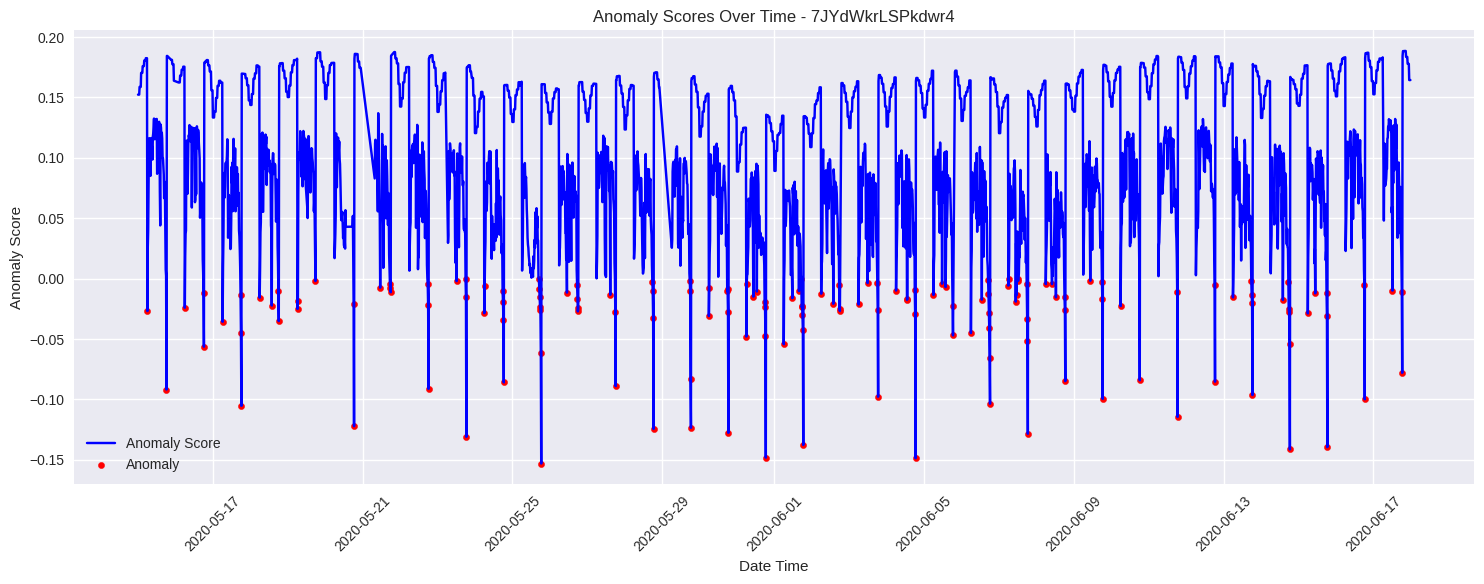

✓ Anomaly plot saved to: plots/anomaly_plot_7JYdWkrLSPkdwr4.png


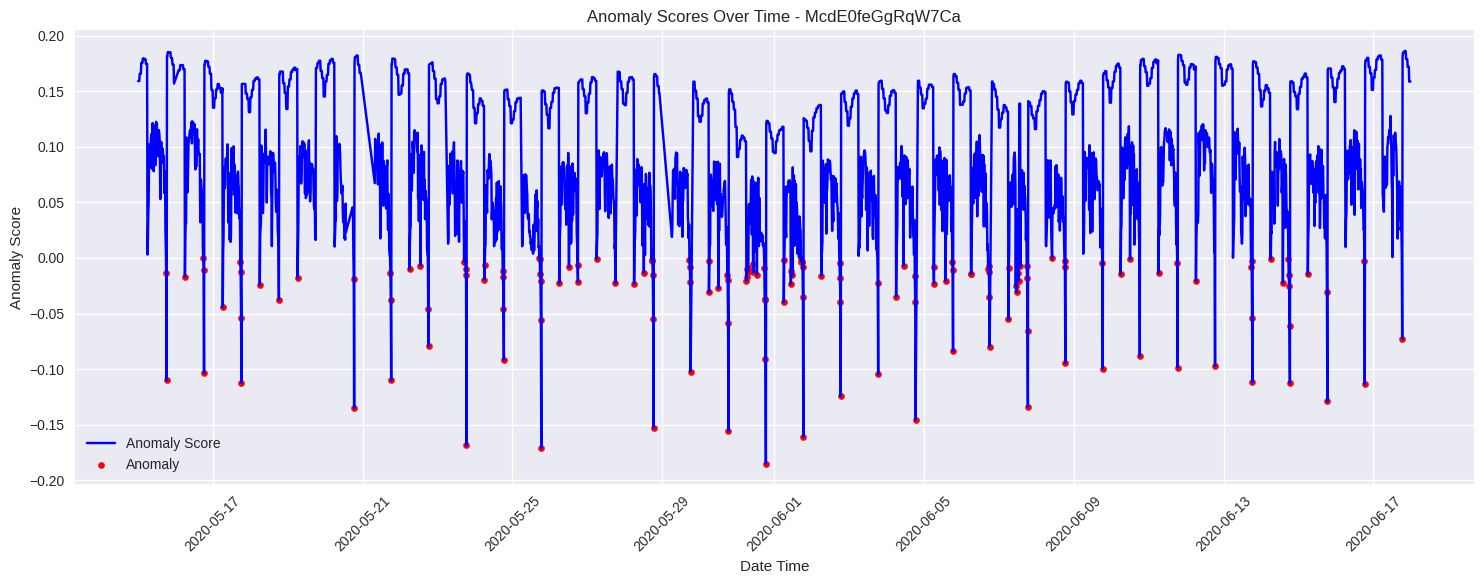

✓ Anomaly plot saved to: plots/anomaly_plot_McdE0feGgRqW7Ca.png


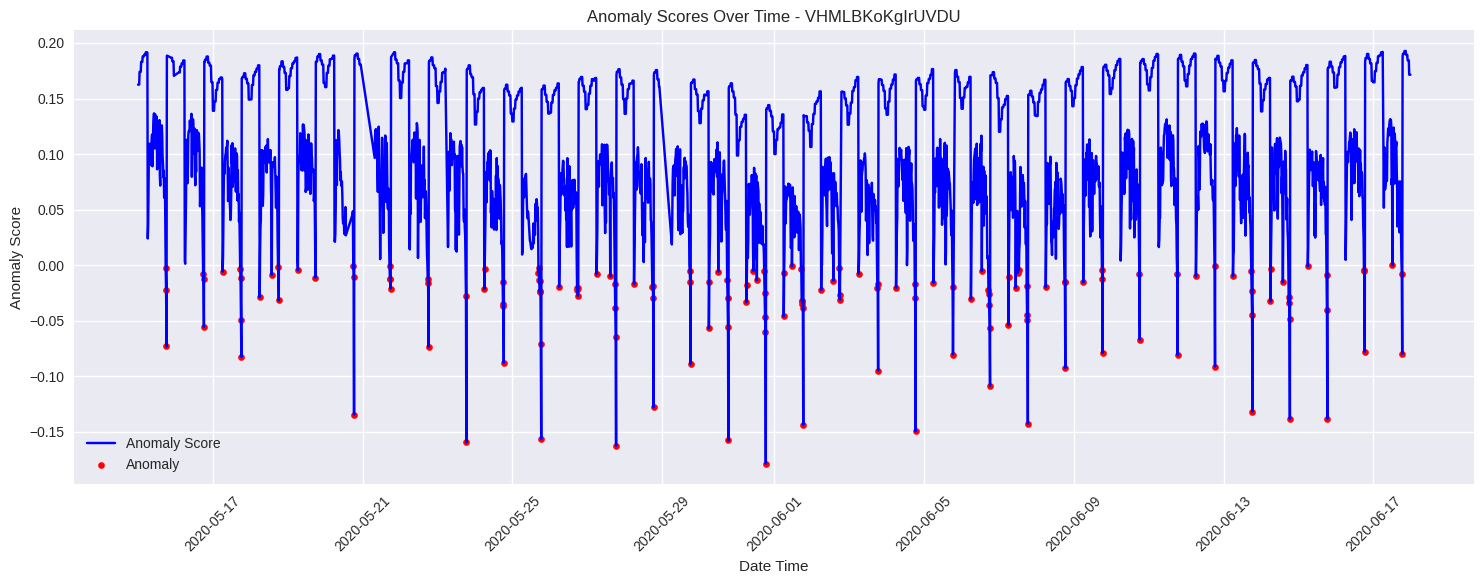

✓ Anomaly plot saved to: plots/anomaly_plot_VHMLBKoKgIrUVDU.png


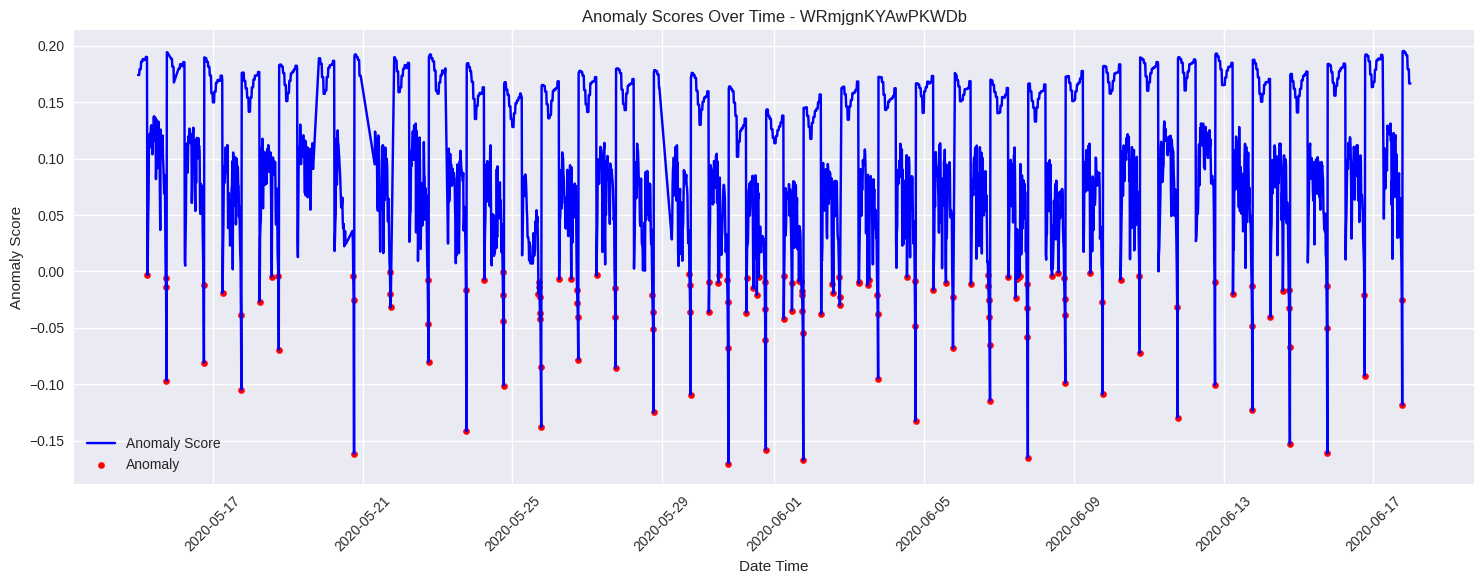

✓ Anomaly plot saved to: plots/anomaly_plot_WRmjgnKYAwPKWDb.png


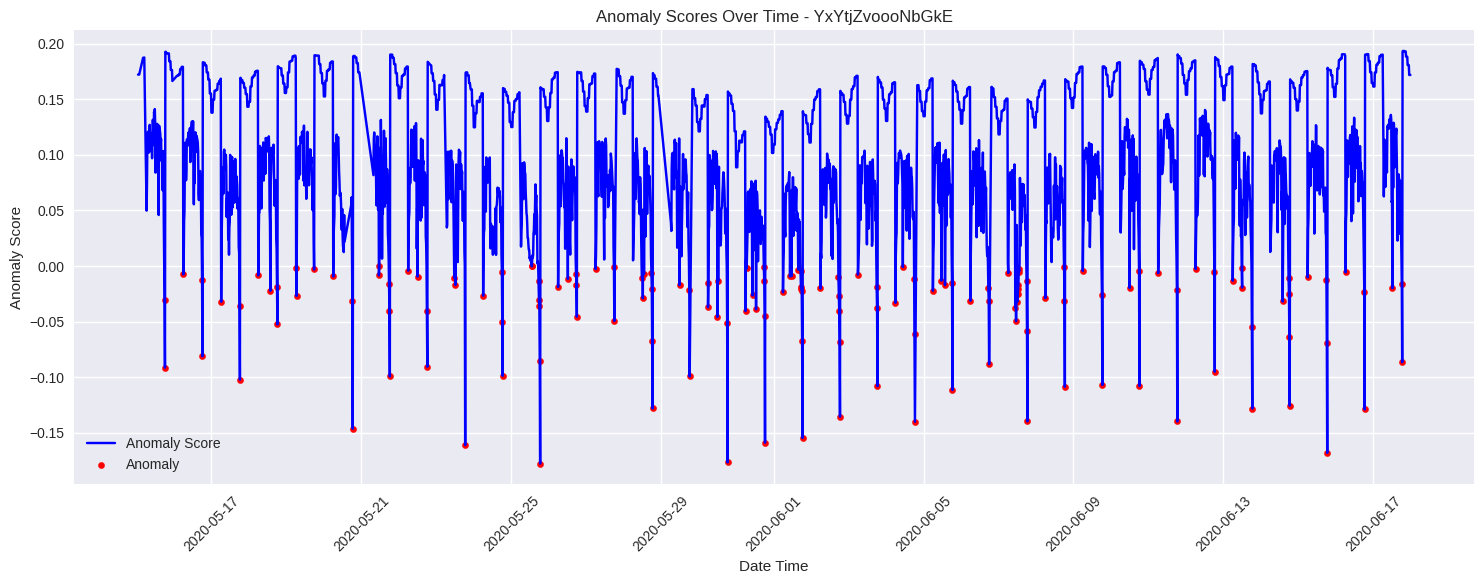

✓ Anomaly plot saved to: plots/anomaly_plot_YxYtjZvoooNbGkE.png


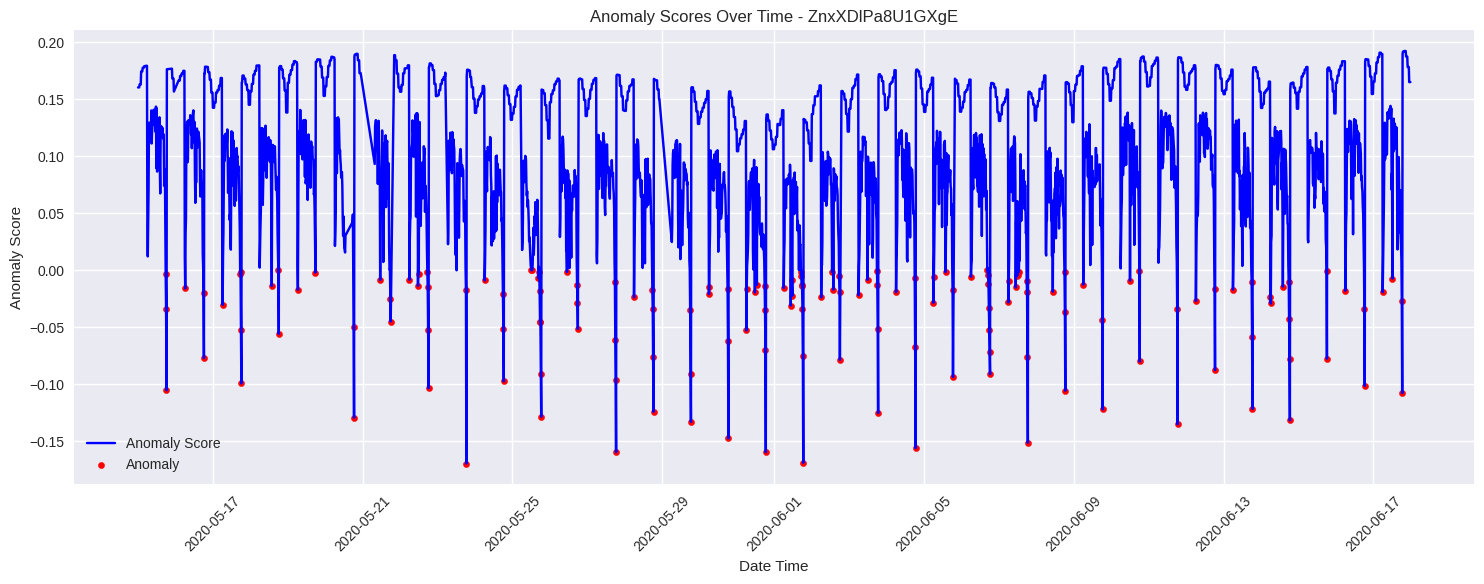

✓ Anomaly plot saved to: plots/anomaly_plot_ZnxXDlPa8U1GXgE.png


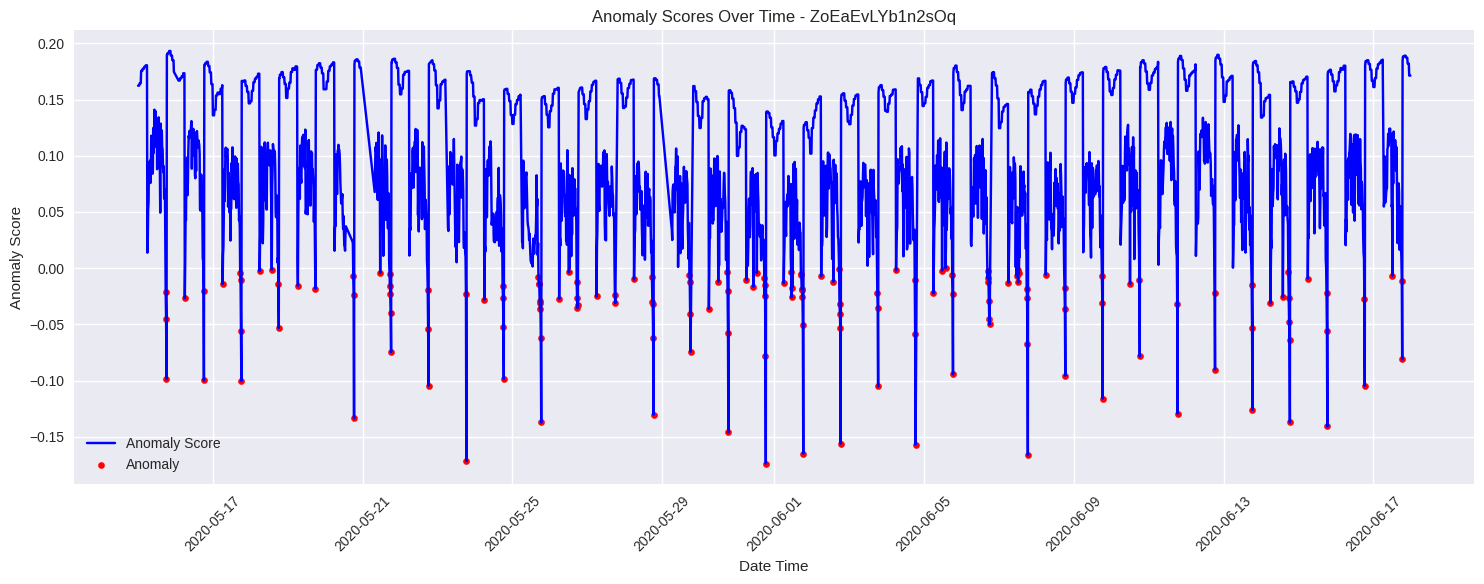

✓ Anomaly plot saved to: plots/anomaly_plot_ZoEaEvLYb1n2sOq.png


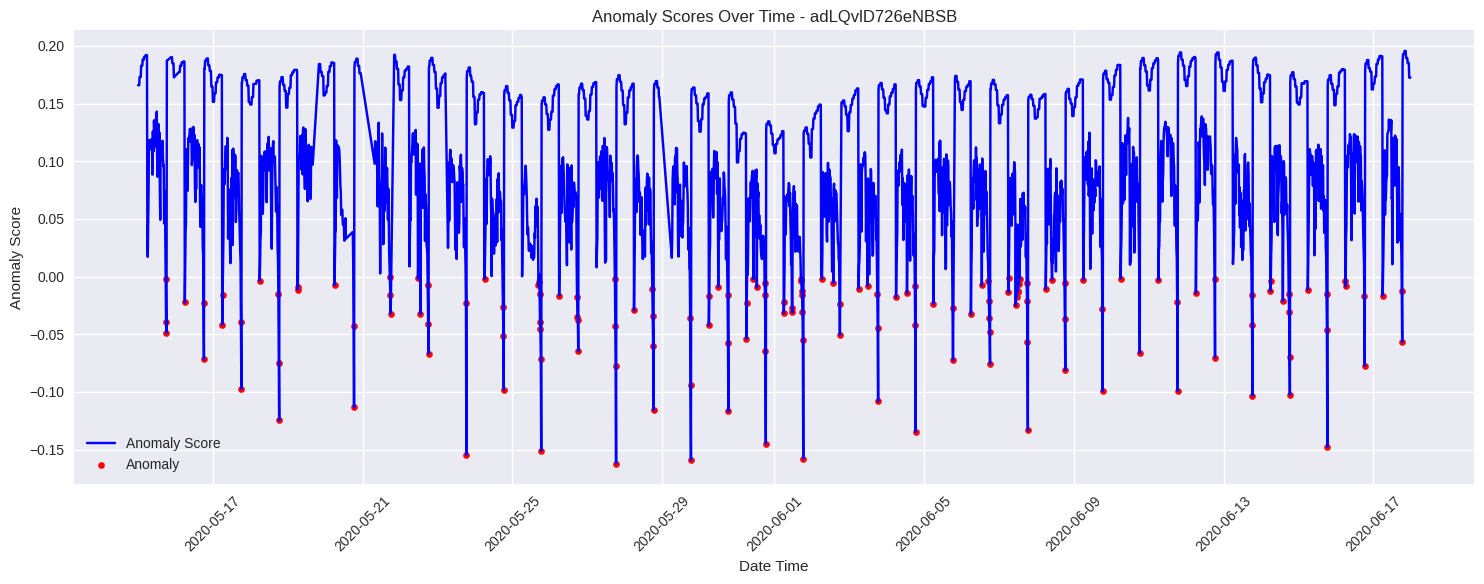

✓ Anomaly plot saved to: plots/anomaly_plot_adLQvlD726eNBSB.png


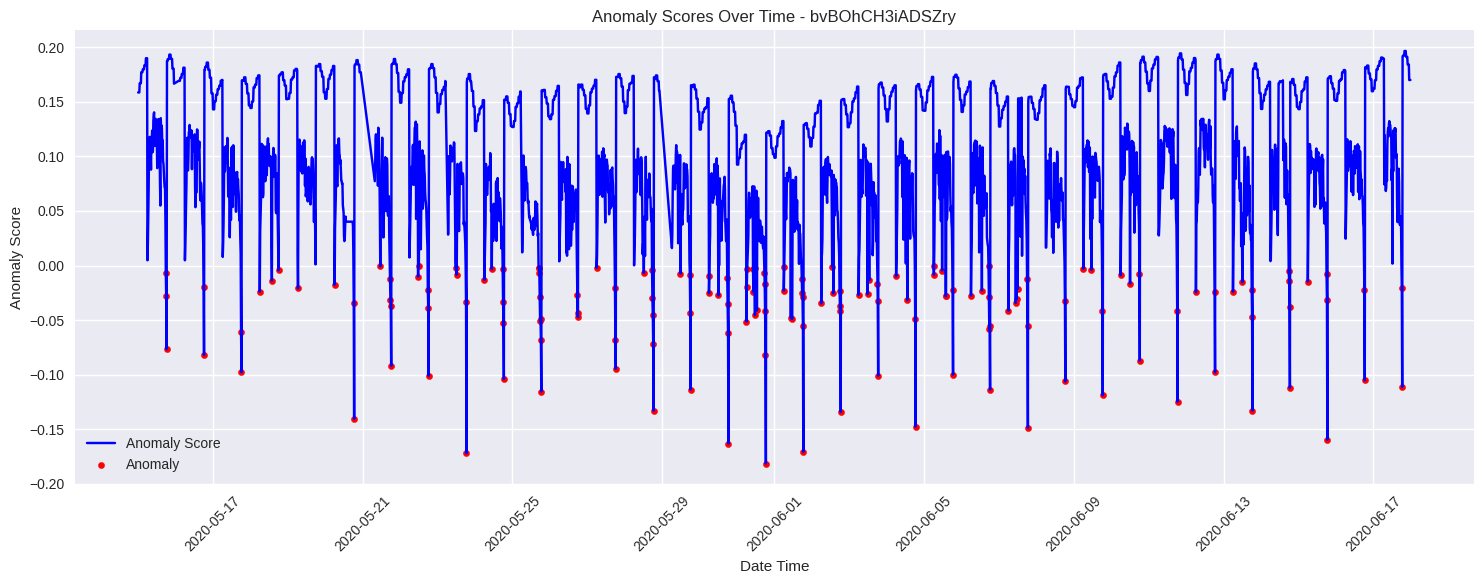

✓ Anomaly plot saved to: plots/anomaly_plot_bvBOhCH3iADSZry.png


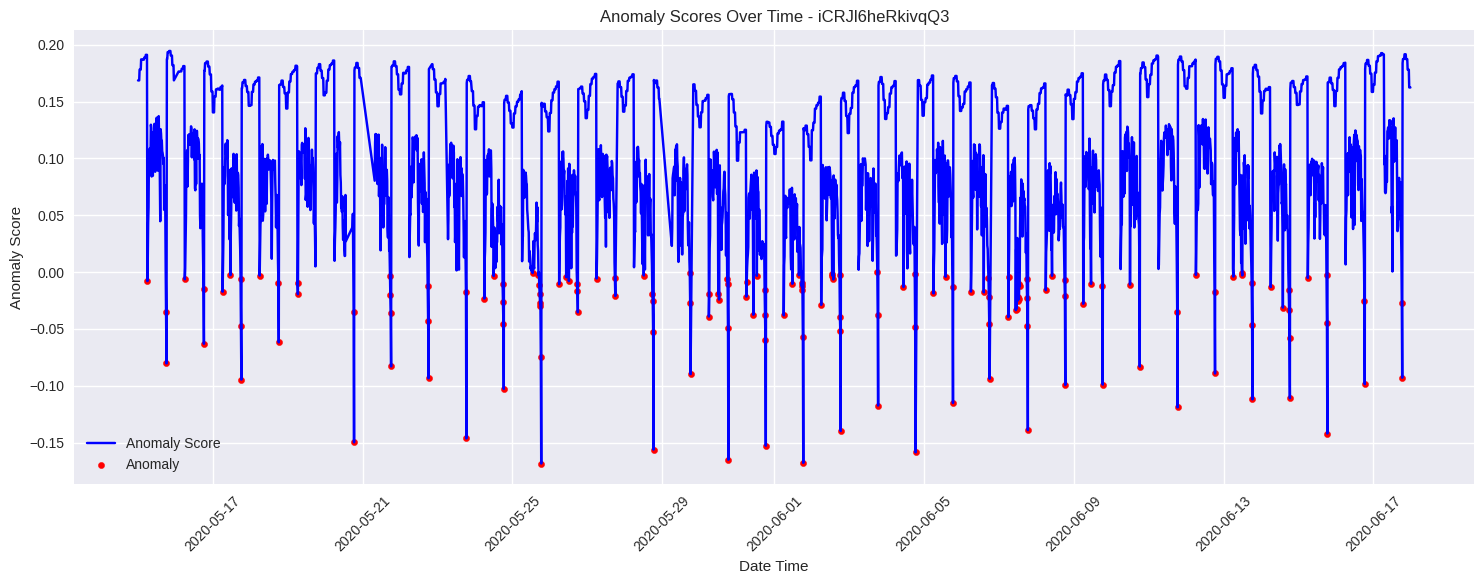

✓ Anomaly plot saved to: plots/anomaly_plot_iCRJl6heRkivqQ3.png


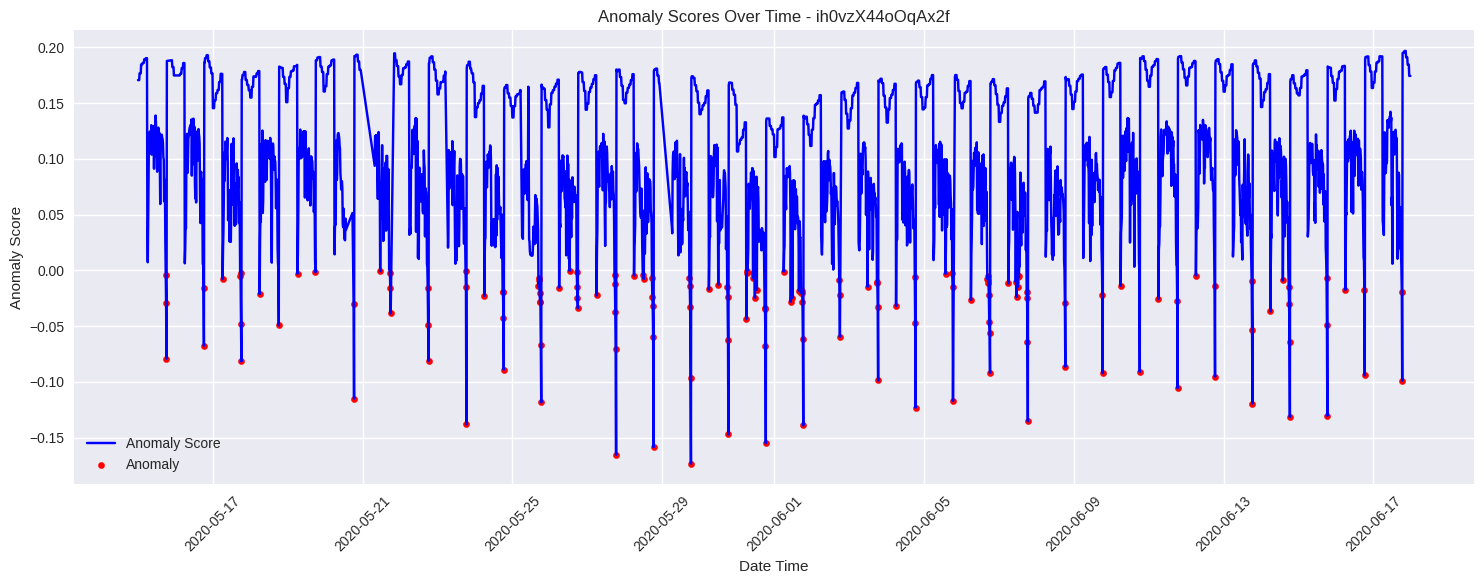

✓ Anomaly plot saved to: plots/anomaly_plot_ih0vzX44oOqAx2f.png


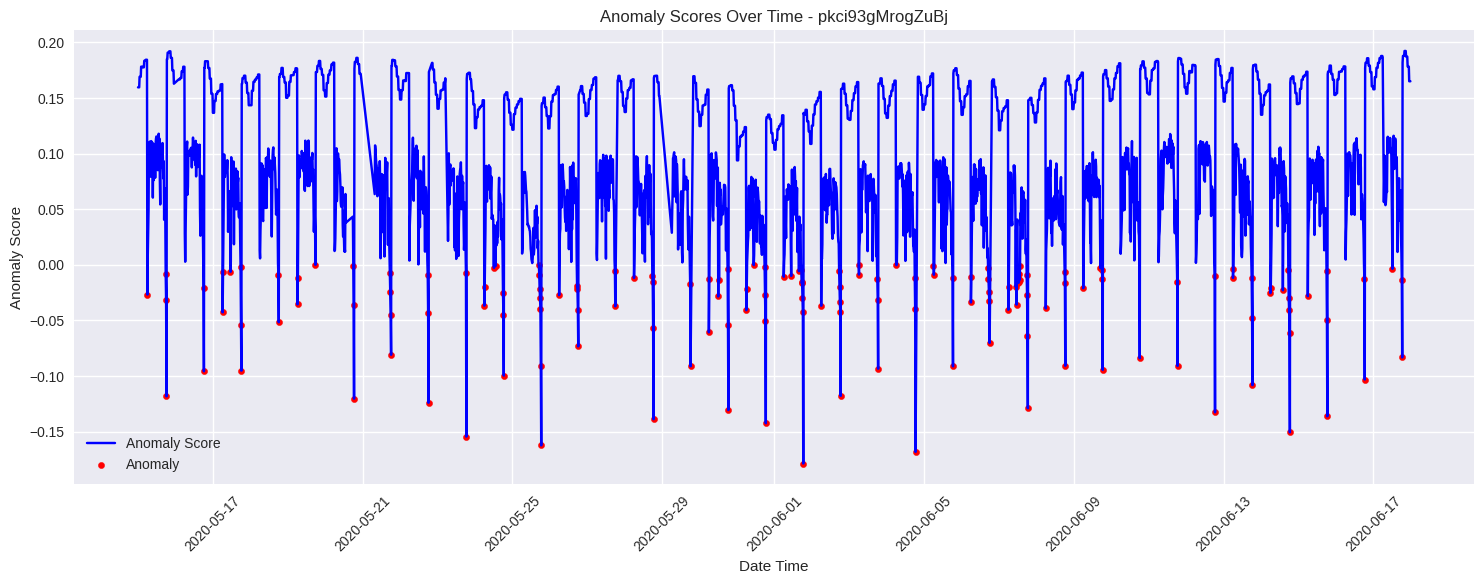

✓ Anomaly plot saved to: plots/anomaly_plot_pkci93gMrogZuBj.png


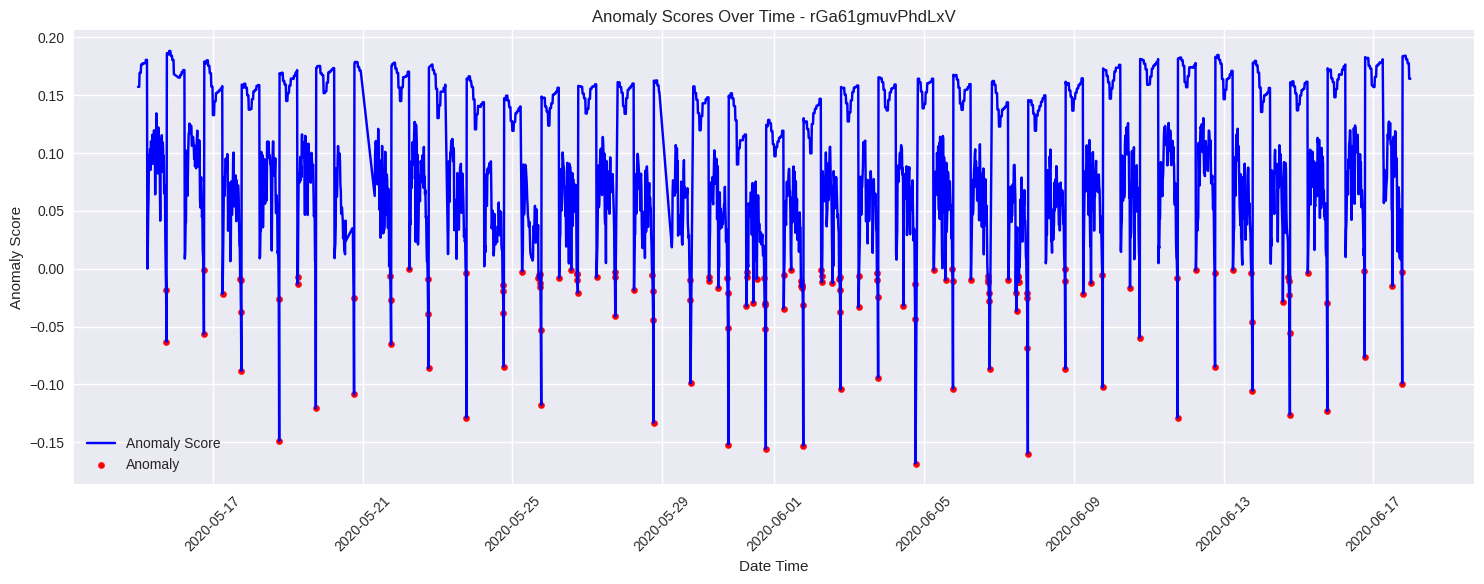

✓ Anomaly plot saved to: plots/anomaly_plot_rGa61gmuvPhdLxV.png


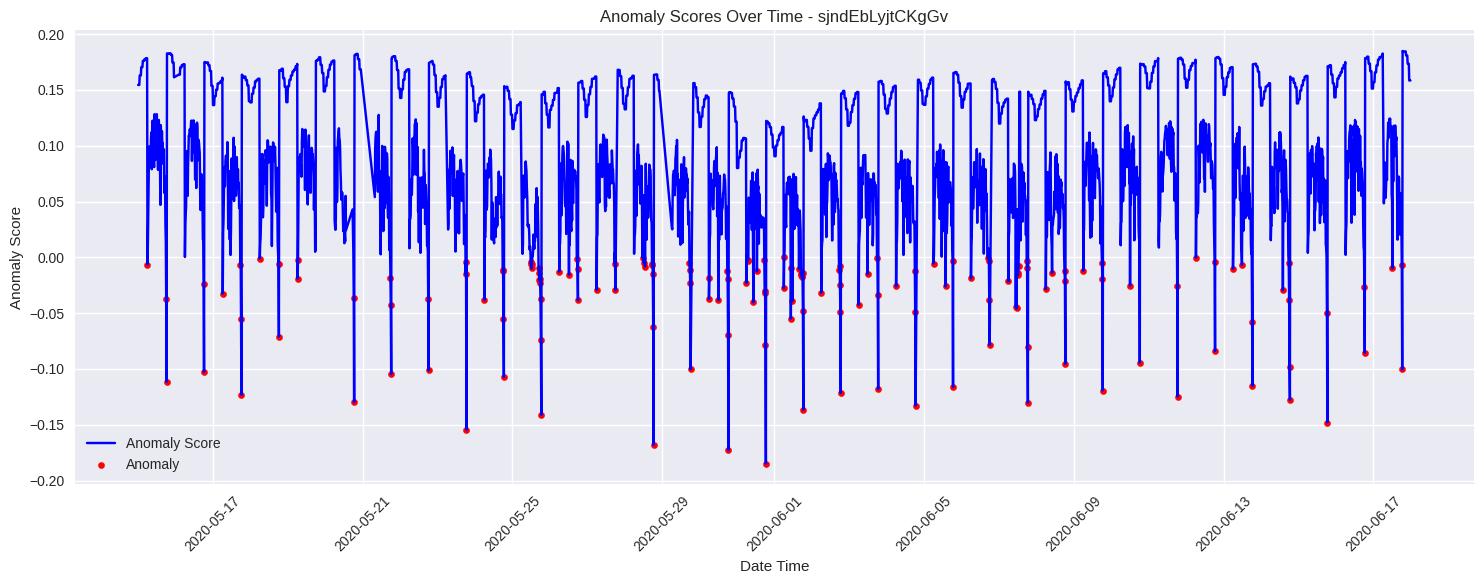

✓ Anomaly plot saved to: plots/anomaly_plot_sjndEbLyjtCKgGv.png


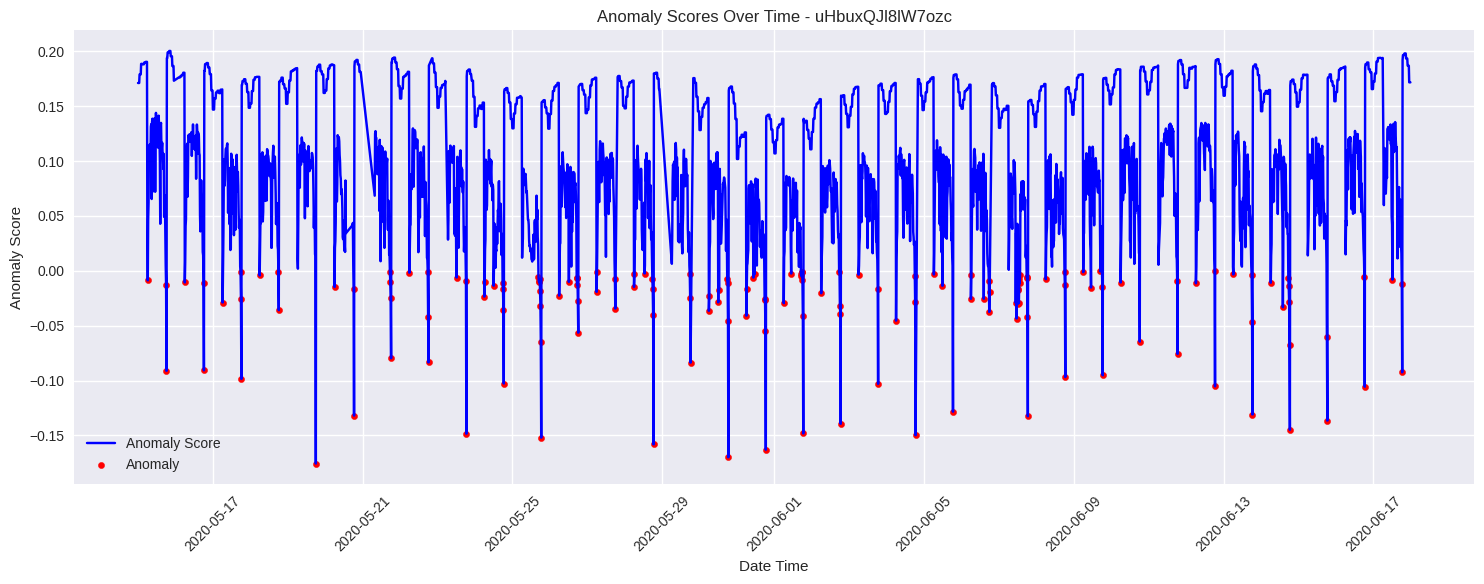

✓ Anomaly plot saved to: plots/anomaly_plot_uHbuxQJl8lW7ozc.png


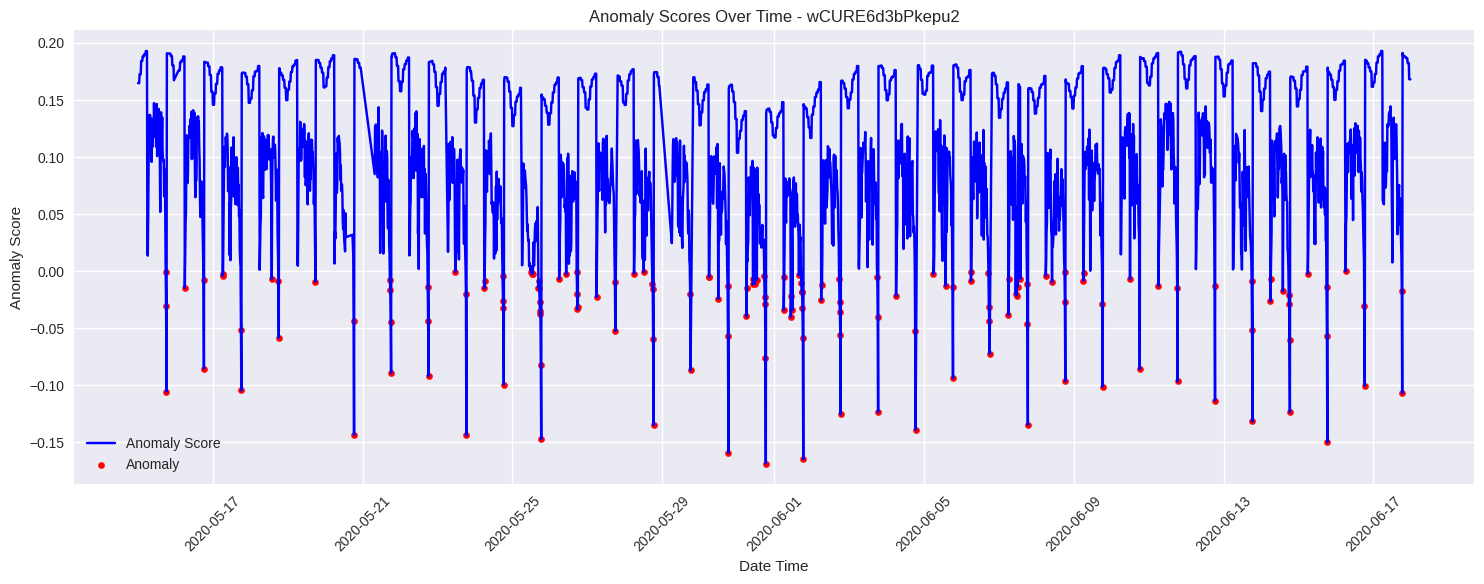

✓ Anomaly plot saved to: plots/anomaly_plot_wCURE6d3bPkepu2.png


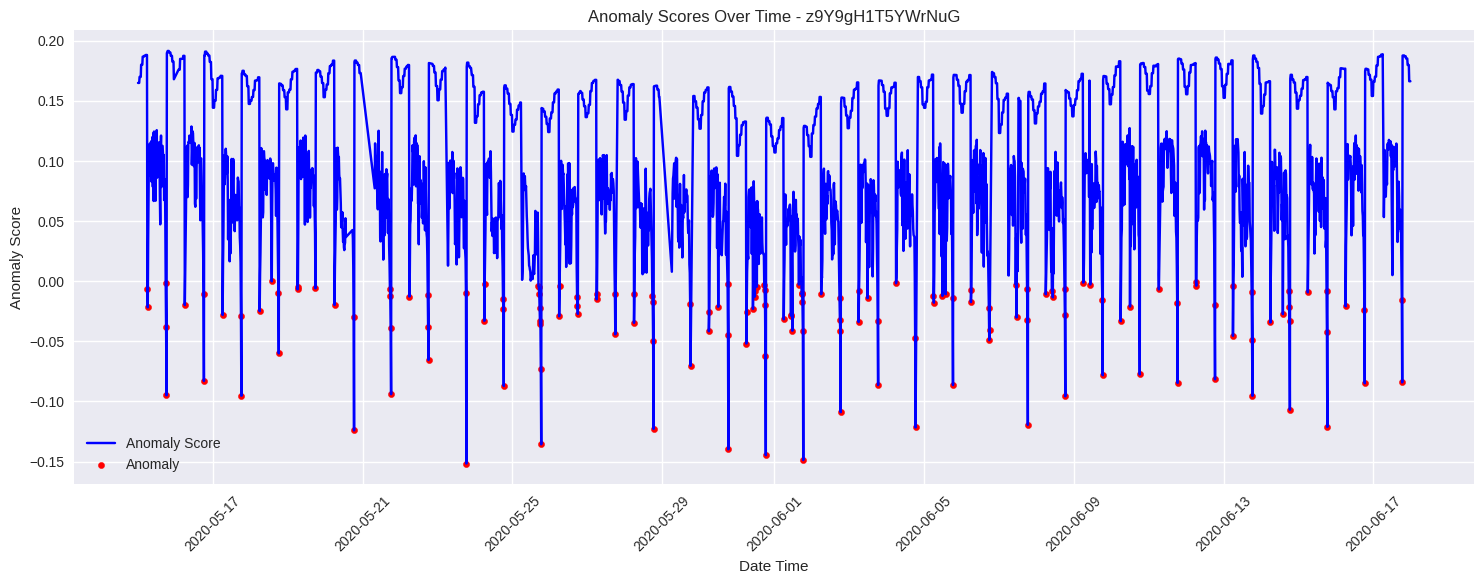

✓ Anomaly plot saved to: plots/anomaly_plot_z9Y9gH1T5YWrNuG.png


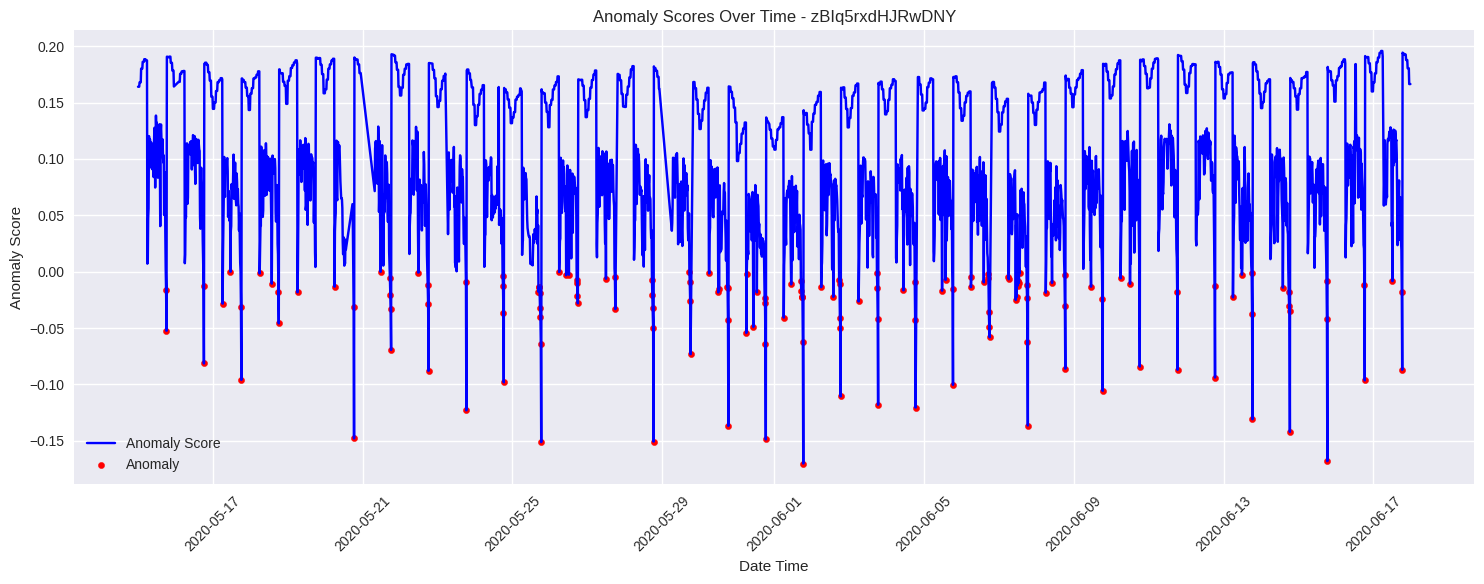

✓ Anomaly plot saved to: plots/anomaly_plot_zBIq5rxdHJRwDNY.png


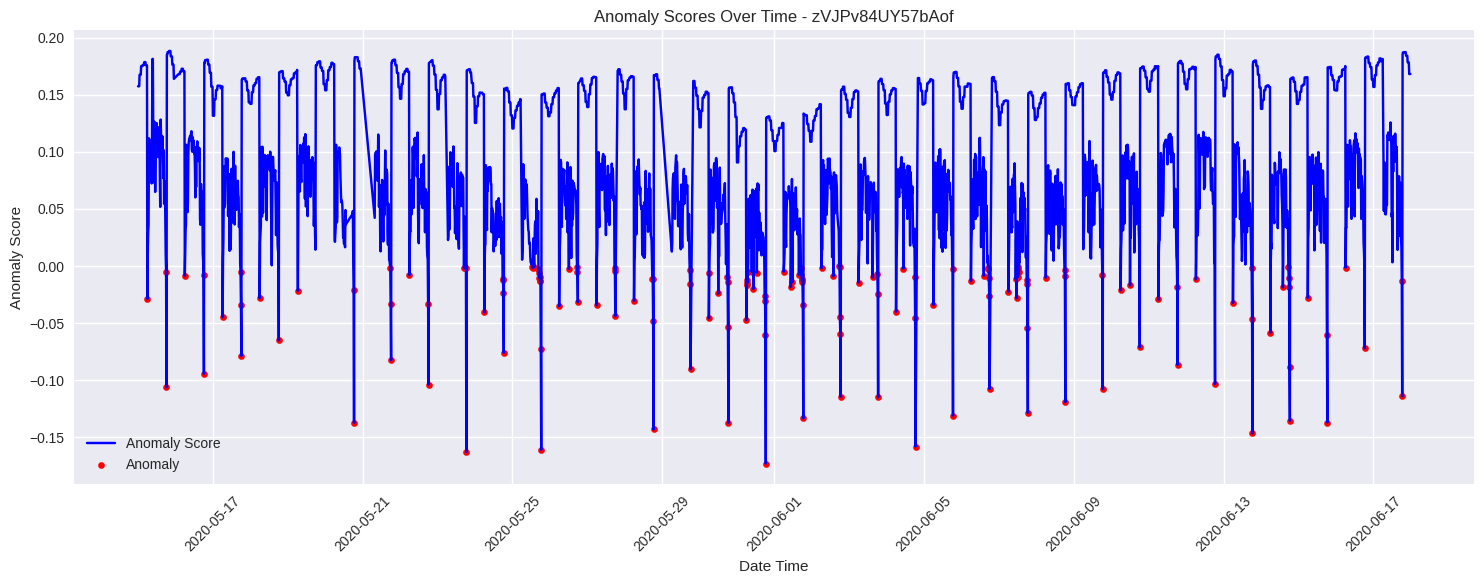

✓ Anomaly plot saved to: plots/anomaly_plot_zVJPv84UY57bAof.png
✓ Saved 158 anomalies → anomalies/anomalies_1BY6WEcLGh8j5v7.csv
✓ Saved 156 anomalies → anomalies/anomalies_1IF53ai7Xc0U56Y.csv
✓ Saved 156 anomalies → anomalies/anomalies_3PZuoBAID5Wc2HD.csv
✓ Saved 157 anomalies → anomalies/anomalies_7JYdWkrLSPkdwr4.csv
✓ Saved 157 anomalies → anomalies/anomalies_McdE0feGgRqW7Ca.csv
✓ Saved 157 anomalies → anomalies/anomalies_VHMLBKoKgIrUVDU.csv
✓ Saved 156 anomalies → anomalies/anomalies_WRmjgnKYAwPKWDb.csv
✓ Saved 156 anomalies → anomalies/anomalies_YxYtjZvoooNbGkE.csv
✓ Saved 157 anomalies → anomalies/anomalies_ZnxXDlPa8U1GXgE.csv
✓ Saved 157 anomalies → anomalies/anomalies_ZoEaEvLYb1n2sOq.csv
✓ Saved 156 anomalies → anomalies/anomalies_adLQvlD726eNBSB.csv
✓ Saved 158 anomalies → anomalies/anomalies_bvBOhCH3iADSZry.csv
✓ Saved 157 anomalies → anomalies/anomalies_iCRJl6heRkivqQ3.csv
✓ Saved 157 anomalies → anomalies/anomalies_ih0vzX44oOqAx2f.csv
✓ Saved 157 anomalies → anomalies/anomal

In [47]:
# STEP 0: Instantiate the model
detector = SCADAAnomalyDetector(contamination=0.05)  # or 0.1 depending on how strict you want

# STEP 1: Load dataset
csv_path = "/content/Generation_Data.csv"  # <-- Replace if your file is in a different path
detector.load_data(csv_path)

# STEP 2: Preprocess
detector.preprocess_data()

# STEP 3: Exploratory Data Analysis
detector.exploratory_data_analysis()

# STEP 4 : FEATURE SELECTION & NORMALIZATION
detector.prepare_features()
# Step 5 : TRAIN ISOLATION FOREST MODELS
detector.train_isolation_forest()
# STEP 6 : VISUALIZE ANOMALIES FOR EACH INVERTER
# detector.plot_anomalies("1BY6WEcLGh8j5v7")
for key in detector.feature_matrix.keys():
    detector.plot_anomalies(key)
# Step 7 : EXPORT ANOMALY DETAILS (PER INVERTER)
detector.export_anomalies()
# STEP 8: IMPLEMENT STATISTICAL METHODS FOR ANOMALY DETECTION
detector.implement_statistical_methods()
# STEP 9: EXPORT COMBINED ANOMALY REPORT
detector.export_combined_anomaly_report()
